## Indexing 
We decided to index the recipes based on the titles and directions, in order to perform keyword search over them. We choose the directions since they will likely contains both ingredients and keywords relative to the procedure (e.g. baked, fried).

In [1]:
!pip install -q python-terrier==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 18.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pyterrier as pt

if not pt.started():
  pt.init()

/tmp/ipykernel_31/2460995692.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipykernel_31/2460995692.py:6: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [3]:
df = pd.read_csv("/kaggle/input/recipe-sampled-0-25/sampled_dataset.csv")

In [4]:
# Create a list of documents (use 'directions' for indexing)
documents_title = [{'docno': str(i), 'text': text} for i, text in enumerate(df['title'])]

# Create the index
indexer = pt.IterDictIndexer("./index_title")
indexer.index(documents_title)

07:46:47.792 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (194) - further warnings are suppressed
07:47:12.317 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 46 empty documents


<org.terrier.querying.IndexRef at 0x7cec031c0830 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x130c7170 at 0x7cec4abbc810>>

In [5]:
# Create a list of documents (use 'directions' for indexing)
documents_directions = [{'docno': str(i), 'text': text} for i, text in enumerate(df['directions'])]

# Create the index
indexer = pt.IterDictIndexer("./index_directions")
indexer.index(documents_directions)

07:47:22.087 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (61876) - further warnings are suppressed
07:48:37.469 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 4 empty documents


<org.terrier.querying.IndexRef at 0x7cebec64ec90 jclass=org/terrier/querying/IndexRef jself=<LocalRef obj=0x130c7168 at 0x7cec4abbfe50>>

In [6]:
# Create documents with multiple fields
documents_fields = [
    {
        'docno': str(i),
        'title': row['title'],
        'ingredients': row['ingredients'],
        'directions': row['directions']
    }
    for i, row in df.iterrows()
]

# Index the fielded documents
indexer_fields = pt.IterDictIndexer("./index_fields")

# Set meta fields and indexed fields
indexref = indexer_fields.index(
    documents_fields,
    fields=["title", "ingredients", "directions"],  
    meta={'docno': 20, 'title': 512, 'ingredients': 1024, 'directions': 4096}
)

In [8]:
# Create a searcher using the index
index_title = pt.IndexFactory.of("./index_title")
index_directions = pt.IndexFactory.of("./index_directions")
index_fields = pt.IndexFactory.of(indexref)

# BM25 retrieval model
bm25_tit = pt.terrier.Retriever(index_title, wmodel="BM25")
bm25_dir = pt.terrier.Retriever(index_directions, wmodel="BM25")

# TF-IDF retrieval model
tfidf_tit = pt.terrier.Retriever(index_title, wmodel="TF_IDF")
tfidf_dir = pt.terrier.Retriever(index_directions, wmodel="TF_IDF")

# DFRee retrieval model (Document Frequency based)
dfree_tit = pt.terrier.Retriever(index_title, wmodel="DFRee")
dfree_dir = pt.terrier.Retriever(index_directions, wmodel="DFRee")

# Create BM25F retriever with field weights
# Weighted BM25 over each field
bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")

# Weighted combination of scores: BM25F-like
bm25f_manual = (
    bm25_title * 0.3 +
    bm25_ingredients * 0.4 +
    bm25_directions * 0.3
)

/tmp/ipykernel_31/2322532848.py:24: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_title = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "title"], field="title")
/tmp/ipykernel_31/2322532848.py:25: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_ingredients = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "ingredients"], field="ingredients")
/tmp/ipykernel_31/2322532848.py:26: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25_directions = pt.BatchRetrieve(index_fields, wmodel="BM25", controls={"w": "1.0"}, metadata=["docno", "directions"], field="directions")


By using all of these models, we can perform a comprehensive evaluation of the different retrieval strategies. Each model captures different aspects of relevance:
- BM25 accounts for both term and document frequencies, providing a balanced relevance score.
- TF-IDF emphasizes the importance of rare terms across the document collection.
- DFRee is useful for understanding how document frequency affects relevance.

We also tried BM25 without term frequency (no tf), but it performed to same as classic BM25. This is likely because in our dataset, document length and term frequency did not vary significantly across relevant documents, so removing the tf component had minimal impact on ranking.  
To keep the notebook clean we omitted this variant.

In [10]:
print(index_title.getCollectionStatistics().toString())
print(index_directions.getCollectionStatistics().toString())
print(index_fields.getCollectionStatistics().toString())

Number of documents: 557658
Number of terms: 34052
Number of postings: 1858185
Number of fields: 1
Number of tokens: 1866522
Field names: [text]
Positions:   false

Number of documents: 557658
Number of terms: 50996
Number of postings: 22626961
Number of fields: 1
Number of tokens: 30780702
Field names: [text]
Positions:   false

Number of documents: 557658
Number of terms: 79107
Number of postings: 32435802
Number of fields: 3
Number of tokens: 55309358
Field names: [title, ingredients, directions]
Positions:   false



In [28]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models for the titles including BM25F
    result_bm25_tit = bm25_tit.search(q['query'])
    result_tfidf_tit = tfidf_tit.search(q['query'])
    result_dfree_tit = dfree_tit.search(q['query'])   

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25_tit),
        ("TF-IDF", result_tfidf_tit),
        ("DFRee", result_dfree_tit),
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, (docno, score) in enumerate(zip(result["docno"][:5], result["score"][:5])):
            docno_int = int(docno)  # Convert from str to int
            title = titles.iloc[docno_int] if docno_int < len(titles) else "TITLE NOT FOUND"
            print(f"DocNO: {docno:<7} | Title: {title:<50.48} | Score: {score:.4f}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title,
                'Score': score
            })



=== Query 1: chicken casserole ===

--- Method: BM25 ---
DocNO: 345320  | Title: Chicken Casserole With No Chicken                  | Score: 9.7953
DocNO: 592     | Title: Chicken Casserole                                  | Score: 9.7166
DocNO: 617     | Title: Chicken Casserole                                  | Score: 9.7166
DocNO: 749     | Title: Chicken Casserole                                  | Score: 9.7166
DocNO: 789     | Title: Chicken Casserole                                  | Score: 9.7166

--- Method: TF-IDF ---
DocNO: 345320  | Title: Chicken Casserole With No Chicken                  | Score: 5.5855
DocNO: 592     | Title: Chicken Casserole                                  | Score: 5.5251
DocNO: 617     | Title: Chicken Casserole                                  | Score: 5.5251
DocNO: 749     | Title: Chicken Casserole                                  | Score: 5.5251
DocNO: 789     | Title: Chicken Casserole                                  | Score: 5.5251

--- Met

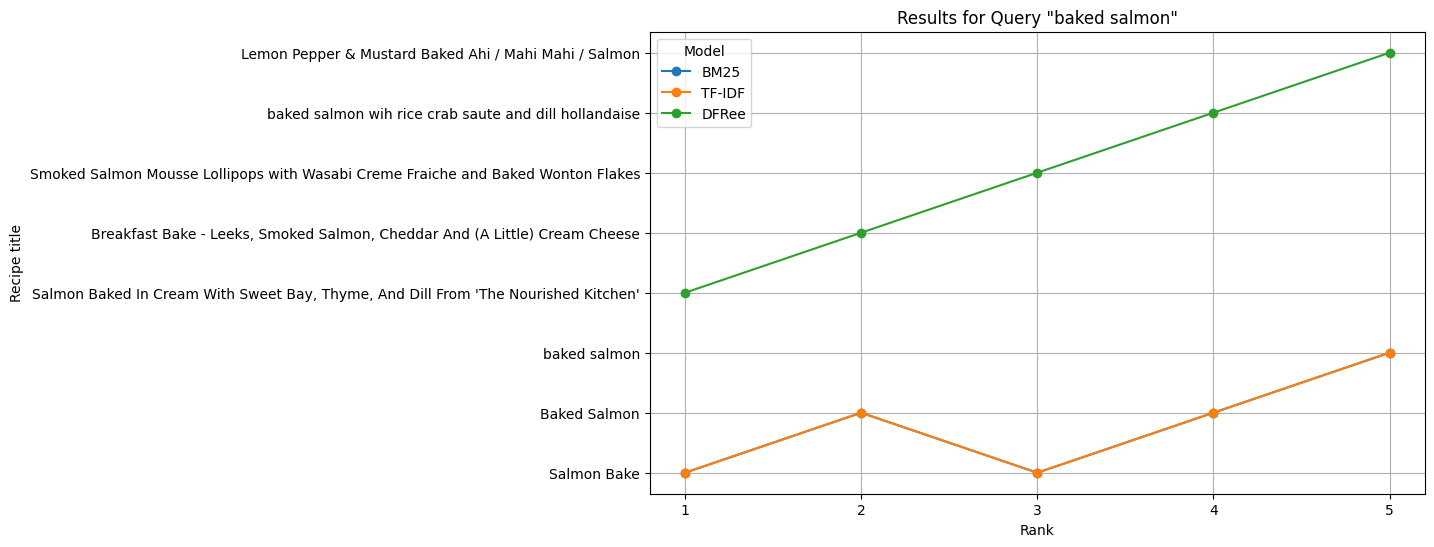

In [29]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

In this case, BM25 and TF-IDF yielded the same document rankings: this happen when documents are short, uniformly sized, or when term frequencies are relatively balanced, making the additional complexity of BM25 less impactful.

This suggest that relying only on document titles for indexing provides limited term variability and context, reducing the effectiveness of retrieval models. Incorporating richer textual content would likely yield more discriminative and informative rankings.

In [26]:
# Prepare some queries and evaluate them
queries = [
    {"qid": "1", "query": "chicken casserole"},
    {"qid": "2", "query": "simple birthday cake"},
    {"qid": "3", "query": "baked salmon"},
]

titles = df['title']
plot_data = []

# Loop through each query
for q in queries:
    print(f"\n=== Query {q['qid']}: {q['query']} ===")

    # Run all models for the directions including BM25F
    result_bm25_dir = bm25_dir.search(q['query'])
    result_tfidf_dir = tfidf_dir.search(q['query'])
    result_dfree_dir = dfree_dir.search(q['query'])
    
    result_bm25f = bm25f_manual.search(q['query'])  

    # Add all model results to the loop
    for method_name, result in [
        ("BM25", result_bm25_dir),
        ("TF-IDF", result_tfidf_dir),
        ("DFRee", result_dfree_dir),
        ("BM25F", result_bm25f) 
    ]:
        print(f"\n--- Method: {method_name} ---")

        for rank, (docno, score) in enumerate(zip(result["docno"][:5], result["score"][:5])):
            docno_int = int(docno)  # Convert from str to int
            title = titles.iloc[docno_int] if docno_int < len(titles) else "TITLE NOT FOUND"
            print(f"DocNO: {docno:<7} | Title: {title:<50.48} | Score: {score:.4f}")
            
            # Append to plotting data
            plot_data.append({
                'Query': q['query'],
                'Query_ID': q['qid'],
                'Model': method_name,
                'Rank': rank + 1,
                'Docno': docno_int,
                'Title': title,
                'Score': score
            })



=== Query 1: chicken casserole ===


TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00,  9.18q/s]



--- Method: BM25 ---
DocNO: 60998   | Title: Bob'S Deluxe Chicken                               | Score: 13.1101
DocNO: 504597  | Title: Lennie'S Chicken And Rice                          | Score: 12.9260
DocNO: 329261  | Title: Quick Chicken Pot Pie                              | Score: 12.7613
DocNO: 130370  | Title: Chicken Enchiladas                                 | Score: 12.6538
DocNO: 444448  | Title: Kings Ranch Chicken Casserole                      | Score: 12.6530

--- Method: TF-IDF ---
DocNO: 60998   | Title: Bob'S Deluxe Chicken                               | Score: 7.5741
DocNO: 504597  | Title: Lennie'S Chicken And Rice                          | Score: 7.4604
DocNO: 329261  | Title: Quick Chicken Pot Pie                              | Score: 7.3653
DocNO: 444448  | Title: Kings Ranch Chicken Casserole                      | Score: 7.3130
DocNO: 130370  | Title: Chicken Enchiladas                                 | Score: 7.3032

--- Method: DFRee ---
DocNO: 444448  |

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00, 10.40q/s]



--- Method: BM25 ---
DocNO: 470068  | Title: Tiny Fruitcakes                                    | Score: 25.9598
DocNO: 318994  | Title: Decorative Icing                                   | Score: 25.0145
DocNO: 358491  | Title: Popcorn Balls(That Stay Soft)                      | Score: 23.0918
DocNO: 65593   | Title: Cranberry Sparkler                                 | Score: 21.9094
DocNO: 483258  | Title: Aperol Spritz                                      | Score: 21.9094

--- Method: TF-IDF ---
DocNO: 470068  | Title: Tiny Fruitcakes                                    | Score: 14.3205
DocNO: 318994  | Title: Decorative Icing                                   | Score: 13.7805
DocNO: 358491  | Title: Popcorn Balls(That Stay Soft)                      | Score: 12.7432
DocNO: 65593   | Title: Cranberry Sparkler                                 | Score: 12.0699
DocNO: 483258  | Title: Aperol Spritz                                      | Score: 12.0699

--- Method: DFRee ---
DocNO: 2890

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00,  8.17q/s]


--- Method: BM25 ---
DocNO: 233225  | Title: Yummy Salmon                                       | Score: 13.5836
DocNO: 300496  | Title: Balsamic Glazed Salmon                             | Score: 13.4833
DocNO: 69969   | Title: Lavender Honey Salmon                              | Score: 13.4589
DocNO: 102573  | Title: Oven-baked salmon                                  | Score: 13.4547
DocNO: 418148  | Title: Fennel- And Dill-Rubbed Grilled Salmon             | Score: 13.3933

--- Method: TF-IDF ---
DocNO: 300496  | Title: Balsamic Glazed Salmon                             | Score: 8.5371
DocNO: 418148  | Title: Fennel- And Dill-Rubbed Grilled Salmon             | Score: 8.4750
DocNO: 69969   | Title: Lavender Honey Salmon                              | Score: 8.4521
DocNO: 385339  | Title: Lemon-Pepper Salmon Ii                             | Score: 8.3394
DocNO: 287067  | Title: Baked Salmon with Black Olive Salsa                | Score: 8.2942

--- Method: DFRee ---
DocNO: 418148  |

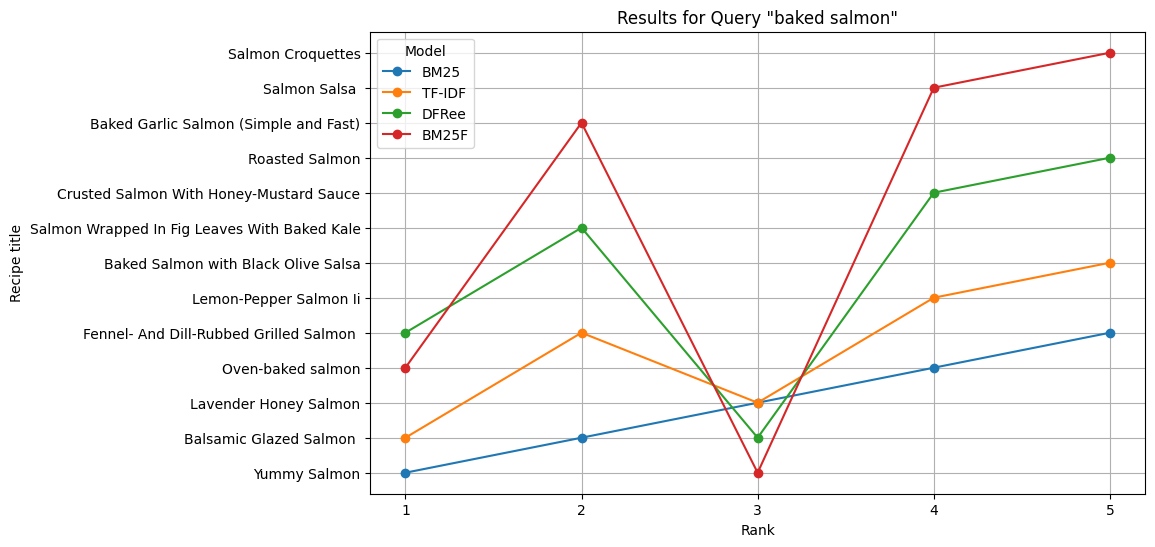

In [27]:
# Visualize the results of the third query
plot_df = pd.DataFrame(plot_data)
df_first = plot_df[plot_df['Query_ID'] == "3"]

plt.figure(figsize=(10, 6))

for model in df_first['Model'].unique():
    md = df_first[df_first['Model'] == model]
    plt.plot(md['Rank'], md['Title'], marker='o', linestyle='-', label=model)

plt.xlabel('Rank')
plt.ylabel('Recipe title')
plt.title(f'Results for Query "{queries[2]["query"]}"')
plt.legend(title='Model')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

About the results:
- TF-IDF put “Balsamic Glazed Salmon” at #1: we can see that TF-IDF’s emphasis on rare terms may be boosting “balsamic”.
- DFRee puts “Fennel-And-Dill-Rubbed Grilled Salmon” at #1, and then “Salmon Wrapped In Fig Leaves With Baked Kale” at #2: it shows that rarer, longer titles win more weight under DFRee.
- Unlike single-field models, BM25F combines weighted evidence from different parts of the document, making it robust when key terms appear in both title, ingredients and directions. 